# Modeling Crop Yield

In [1]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

import math

## Parameters

In [2]:
# satellite = "landsat-8-c2-l2"
satellite = "sentinel-2-l2a"
bands = "2-3-4"
country_code = "ZMB"
points = "15"
num_features = "1000"
feature_file_name = (f'{satellite}_bands-{bands}_{country_code}_{points}'
                     f'k-points_{num_features}-features')

weight_file_name = (f'{country_code}_crop_weights{points}k-points')

## Boundaries 

In [3]:
country_shp = geopandas.read_file(f'/capstone/cropmosaiks/data/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
# country_shp.plot(column = 'district',linewidth = 1, edgecolor = 'black' )
# country_shp

(72, 1)

## Crops

In [4]:
crop_df = pd.read_csv('/capstone/cropmosaiks/data/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
crop_df = crop_df.set_index('district')
# crop_df

In [5]:
list(set(crop_districts) - set(country_districts))

['Ikelenge', 'Mafinga']

In [6]:
list(set(country_districts) - set(crop_districts))

[]

In [7]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Weights

In [8]:
# weights = pd.read_feather(f"data/weights/{weight_file_name}_2018.feather")
# weights.crop_perc = weights.crop_perc.fillna(0)
# weights.crop_perc = weights.crop_perc + 0.0001
# weights

In [9]:
# weights_gdf.plot(figsize = (15,15),
                 # cmap = 'inferno',
                 # cmap = new_cmap,
                 # markersize = 3,
                 # alpha = .9,
                 # column = 'crop_perc')
# plt.axis('off')

## Features

In [10]:
features = geopandas.GeoDataFrame()
year_start = 2016 # this was 2016
year_end = 2018
for yr in range(year_start, year_end + 1):
    print("Opening:", yr)
    print(f"File: {feature_file_name}_{yr}.feather")
    # Read in the file
    features_x = pd.read_feather(f"/capstone/cropmosaiks/data/features/{feature_file_name}_{yr}.feather") 
    # Force years to span the growing season which for Zambia is November to May
    features_x['year'] = np.where(
        features_x['month'].isin(["07", "08", "09", "10", "11", "12"]),
        features_x['year'] + 1, 
        features_x['year']
    ) 
    # The above step makes the ending months of the final dataset to be outside the desired date range
    # Below we get rid of unwanted months by filtering for years in the daterange
    features_x = features_x[features_x['year'] < year_end + 1]
    
    # Here we pivot the data from long format to wide by indexing on 
    # 'lon','lat', "year", 'month' and using the unstack function
    features_x = features_x.set_index(['lon','lat', "year", 'month']).unstack()
    # We then map column names based on the month index and the associated features
    # so month '01' is appended to each feature for that month making 0_01, 1_01 etc. 
    features_x.columns = features_x.columns.map(lambda x: '{}_{}'.format(*x))
    # The index is then reset
    features_x = features_x.reset_index()
    
    # We then make the resulting wide data into a GeoDataFrame
    features_x = geopandas.GeoDataFrame(
        features_x, 
        geometry = geopandas.points_from_xy(x = features_x.lon, y = features_x.lat)
        , crs='EPSG:4326'
    )#.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat']) # Optionally attach weight to each point (% area cropped of surrounding 1 km^2)
    # Drop lon and lat now that they are in geometry column
    features_x = features_x.drop(['lon', 'lat'], axis = 1)
    
    # Join features to crop data with a spatial join
    print("Joining:", yr)
    country_x = country_crop[country_crop.year == yr]
    adm_features = features_x.sjoin(country_x, how = 'left', predicate = 'within')
    
    # Concatenate the joined data into a single GeoDataFrame while looping through years 
    print("Appending:", yr)
    features = geopandas.GeoDataFrame(
        pd.concat([features, adm_features], axis = 0), #, ignore_index=True),
        crs = 'EPSG:4326'
    ).reset_index(drop = True)
    print("features.shape:", features.shape)
    print("")

Opening: 2016
File: sentinel-2-l2a_bands-2-3-4_ZMB_15k-points_1000-features_2016.feather
Joining: 2016
Appending: 2016
features.shape: (15058, 12005)

Opening: 2017
File: sentinel-2-l2a_bands-2-3-4_ZMB_15k-points_1000-features_2017.feather
Joining: 2017
Appending: 2017
features.shape: (30116, 12005)

Opening: 2018
File: sentinel-2-l2a_bands-2-3-4_ZMB_15k-points_1000-features_2018.feather
Joining: 2018
Appending: 2018
features.shape: (45174, 12005)



In [11]:
features = (
    features
    .dropna(subset=['index_right'])
    .drop(['year_right'], axis = 1)
    .rename(columns = {
        "index_right": "district", 
        "year_left": "year"})
    .reset_index(drop = True)
)
features_gdf = features.copy()
features = features.drop(['geometry'], axis = 1)

In [12]:
features[features.district == "Kalabo"]

,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12,district,yield_mt
0,2016,NaN,2.873448,NaN,0.000000,2.212210,2.402290,2.654940,3.324719,3.459881,...,0.317298,0.264029,0.229246,0.205157,0.218025,0.115263,NaN,NaN,Kalabo,0.379483
2,2016,NaN,1.559622,NaN,0.000000,1.598681,1.820313,2.020117,2.836429,3.032127,...,0.556027,0.503105,0.437872,0.326640,0.351121,0.410432,NaN,NaN,Kalabo,0.379483
4,2016,NaN,1.506948,NaN,0.000000,1.790734,1.950166,1.848705,2.680594,2.840220,...,0.410455,0.367934,0.435585,0.366132,0.361482,0.237762,NaN,NaN,Kalabo,0.379483
5,2016,NaN,2.698899,NaN,0.000000,2.508165,2.566103,2.816560,3.439666,3.506521,...,0.364632,0.337255,0.274201,0.182400,0.190279,0.188498,NaN,NaN,Kalabo,0.379483
6,2016,NaN,2.332892,NaN,0.000000,2.416546,2.514813,2.734406,3.271715,3.368680,...,0.393083,0.349183,0.292677,0.256382,0.254309,0.269660,NaN,NaN,Kalabo,0.379483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30789,2018,0.447608,NaN,0.523651,0.460734,0.459956,2.572488,3.255792,3.144312,3.990009,...,0.869640,0.264877,0.154925,0.291433,0.148006,0.052843,0.646895,NaN,Kalabo,0.561618
30790,2018,0.801167,NaN,0.486176,0.391192,0.417064,3.169170,3.569621,3.350463,2.945659,...,0.881541,0.133368,0.103930,0.213581,0.388268,0.135474,0.348248,0.634571,Kalabo,0.561618
30791,2018,2.184312,NaN,0.413057,0.268599,0.278623,1.907096,2.947859,3.164060,3.737794,...,0.901567,0.578022,0.490621,0.454142,0.461313,0.400252,0.313632,0.402986,Kalabo,0.561618
30793,2018,0.731104,NaN,0.422875,0.187567,0.236497,1.885508,2.432036,2.543175,2.772135,...,0.913024,0.428650,0.400366,0.470582,0.507373,0.383811,0.532907,0.636454,Kalabo,0.561618


In [13]:
impute_data = True
# impute_data = False

if impute_data:
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    features = features.set_index(['district', 'year', 'yield_mt',])
    imputer.fit_transform(features)
    features[:] = imputer.transform(features)
    features = features.reset_index()
else:
    features = features.fillna(0)

In [14]:
features

,district,year,yield_mt,0_1,0_2,0_3,0_4,0_5,0_6,0_7,...,999_3,999_4,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12
0,Kalabo,2016,0.379483,1.320903,2.873448,0.907059,0.000000,2.212210,2.402290,2.654940,...,0.794007,1.000000,0.317298,0.264029,0.229246,0.205157,0.218025,0.115263,0.395069,0.595509
1,Chavuma,2016,2.806322,1.320903,0.975753,0.907059,0.729135,0.788392,0.000000,1.265603,...,0.794007,0.679730,0.599122,1.000000,0.583771,0.647212,0.630208,0.394936,0.395069,0.595509
2,Kalabo,2016,0.379483,1.320903,1.559622,0.907059,0.000000,1.598681,1.820313,2.020117,...,0.794007,1.000000,0.556027,0.503105,0.437872,0.326640,0.351121,0.410432,0.395069,0.595509
3,Chavuma,2016,2.806322,1.320903,0.975753,0.907059,0.892818,0.794718,0.000000,1.196233,...,0.794007,0.665637,0.605024,1.000000,0.557448,0.623983,0.601708,0.401900,0.395069,0.595509
4,Kalabo,2016,0.379483,1.320903,1.506948,0.907059,0.000000,1.790734,1.950166,1.848705,...,0.794007,1.000000,0.410455,0.367934,0.435585,0.366132,0.361482,0.237762,0.395069,0.595509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44860,Isoka,2018,3.400556,1.320903,0.407229,0.907059,0.715051,0.278082,0.361583,0.739888,...,0.794007,0.765279,0.691395,0.649757,0.685890,0.595335,0.368329,0.277963,0.563709,0.706688
44861,Isoka,2018,3.400556,1.320903,0.417989,0.907059,0.715051,0.380006,0.521847,1.050478,...,0.794007,0.765279,0.653782,0.579587,0.605632,0.544883,0.255061,0.135804,0.449882,0.621556
44862,Isoka,2018,3.400556,1.320903,0.579601,0.907059,0.715051,0.463194,0.567022,1.012499,...,0.794007,0.765279,0.604434,0.543202,0.594363,0.484981,0.292553,0.619328,0.799177,0.532493
44863,Chama,2018,1.668139,1.320903,0.466405,0.907059,0.715051,0.363704,0.421998,0.893687,...,0.794007,0.765279,0.653721,0.577936,0.629996,0.525298,0.374809,0.366679,0.727830,0.604610


In [15]:
# features_croppped = features[features.crop_perc > 0]
# features.shape

In [16]:
if satellite == "landsat-8-c2-l2":
    na = features[features.isna().any(axis = 1)]
    na.plot(figsize = (15,15), markersize = 1)
    # plt.savefig(f'images/nans.jpg', dpi=300)
    features = features.dropna()

In [17]:
# features_summary = features.groupby(['district', 'yield_mt' ,"year"], as_index = False
#                                    ).apply(lambda x: np.average(x['0'], weights=x['crop_perc'], axis = 0))
# features_summary

In [18]:
features_summary = features.groupby(['district',"year"], as_index = False).mean()

## Model

In [19]:
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt'], axis = 1)

# y_all = features_summary.yield_mt
y_all = np.log10(features_summary.yield_mt.to_numpy() + 1)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [21]:
len(y_all)

216

In [22]:
len(x_train)

172

In [23]:
len(x_test)

44

In [24]:
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv_random.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

In [25]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance 0.31


In [26]:
# y_pred = np.maximum(ridge_cv_random.predict(x_all), 0)

# plt.figure()
# plt.scatter(y_pred, y_all, alpha=1, s=4)
# plt.xlabel("Predicted", fontsize=15)
# plt.ylabel("Ground Truth", fontsize=15)
# plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
# plt.title(f"Model applied to all data n = {len(x_all)}, R$^2$ = {(r2_score(y_all, y_pred)):0.2f}",
#           fontsize=12, y=1)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# plt.xlim([0, 1])
# plt.ylim([0, 1])

# plt.text(0.1, .75,
#          s="R$^2$ = %0.2f" % (r2_score(y_all, y_pred)),
#          fontsize=15, fontweight="bold")

# m, b = np.polyfit(y_pred, y_all, 1)
# plt.plot(y_pred, m * y_pred + b, color="black")
# plt.gca().spines.right.set_visible(False)
# plt.gca().spines.top.set_visible(False)

# plt.show()
# plt.close()

In [27]:
# spearmanr(y_pred, y_all)

In [28]:
# pearsonr(y_pred, y_all)

In [29]:
# spearmanr(y_pred, y_all)

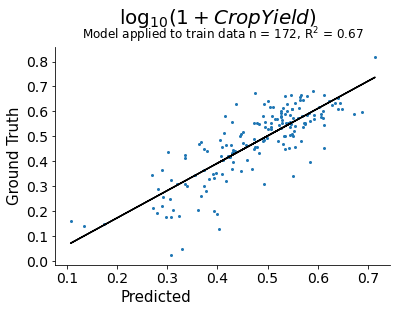

In [30]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)

plt.figure()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {(r2_score(y_train, y_pred)):0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_train, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()

In [31]:
r2_score(y_train, y_pred)

0.6650241518062118

In [32]:
pearsonr(y_pred, y_train)

(0.8185556351979061, 8.744811566515085e-43)

In [33]:
spearmanr(y_pred, y_train)

SpearmanrResult(correlation=0.7901434591991472, pvalue=5.568573252602596e-38)

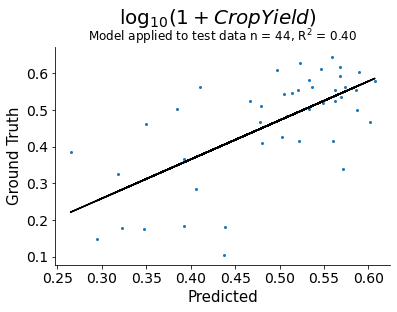

In [34]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {(r2_score(y_test, y_pred)):0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [35]:
r2_score(y_test, y_pred)

0.4032301136362726

In [36]:
pearsonr(y_pred, y_test)

(0.6659452651058393, 8.085322362142268e-07)

In [37]:
spearmanr(y_pred, y_test)

SpearmanrResult(correlation=0.5998590556730091, pvalue=1.6816944844297978e-05)

In [38]:
pred_features = features.copy()
pred_features['geometry'] = features_gdf['geometry']
pred_features = geopandas.GeoDataFrame(pred_features)
x_all = pred_features.drop(['year', 'district', 'geometry', 'yield_mt'], axis = 1)
pred_features['fit'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [39]:
plot_features = pred_features[pred_features.year == 2018]
# plot_features

<AxesSubplot:>

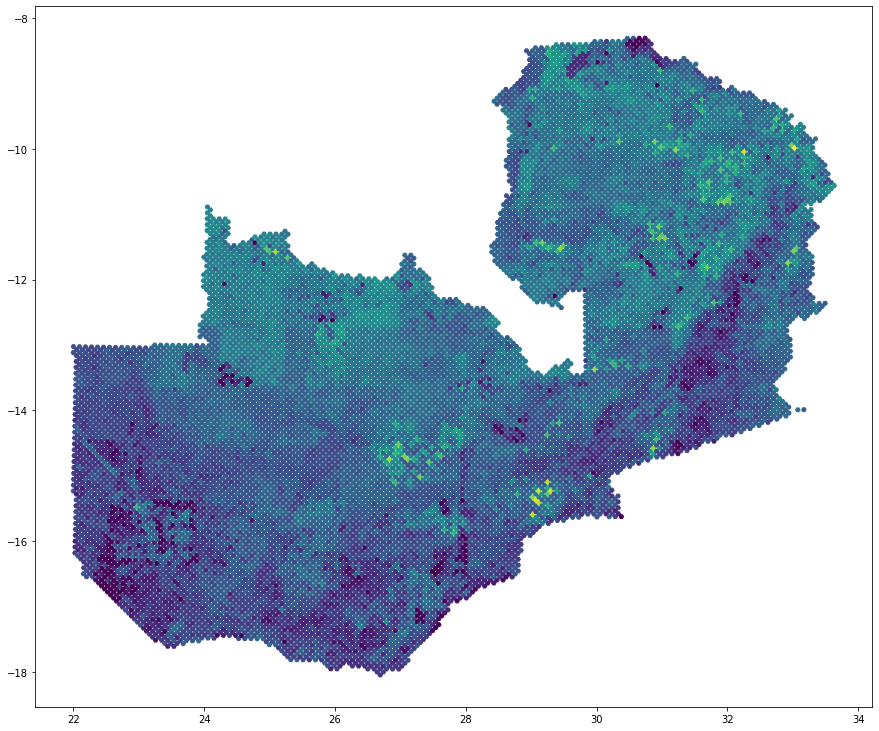

In [40]:
plot_features.plot(figsize = (15,15),
                   marker='H',
                   # legend = True,
                   markersize = 20,
#                    alpha = .9,
                   column = 'fit')

In [41]:
# this is a comment

## Plot Residuals - Years 2016-2018

In [42]:
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt'], axis = 1)

residual_df = pd.DataFrame()

residual_df["yield"] = np.log10(features_summary.yield_mt.to_numpy() + 1)
residual_df["prediction"] = np.maximum(ridge_cv_random.predict(x_all), 0)
residual_df["residual"] = residual_df["yield"] - residual_df["prediction"]
residual_df["demean_yield"] = residual_df["yield"] - residual_df["yield"].mean()
residual_df["demean_prediction"] = residual_df["prediction"] - residual_df["prediction"].mean()
residual_df["year"] = features_summary.year
residual_df["district"] = features_summary.district
residual_df = residual_df.join(country_shp, how = "left", on = "district")
residual_gdf = geopandas.GeoDataFrame(residual_df)
residual_gdf

,yield,prediction,residual,demean_yield,demean_prediction,year,district,geometry
0,0.458853,0.474733,-0.015880,-0.014447,-0.004360,2016,Chadiza,"POLYGON ((32.31720 -13.95683, 32.33500 -13.965..."
1,0.589161,0.534718,0.054443,0.115861,0.055625,2017,Chadiza,"POLYGON ((32.31720 -13.95683, 32.33500 -13.965..."
2,0.361592,0.446901,-0.085309,-0.111708,-0.032192,2018,Chadiza,"POLYGON ((32.31720 -13.95683, 32.33500 -13.965..."
3,0.353619,0.396498,-0.042879,-0.119681,-0.082595,2016,Chama,"POLYGON ((33.27486 -11.43445, 33.27387 -11.434..."
4,0.519567,0.450776,0.068791,0.046266,-0.028317,2017,Chama,"POLYGON ((33.27486 -11.43445, 33.27387 -11.434..."
...,...,...,...,...,...,...,...,...
211,0.341696,0.550414,-0.208718,-0.131604,0.071321,2017,Solwezi,"POLYGON ((27.21271 -11.58675, 27.22162 -11.624..."
212,0.452073,0.611899,-0.159826,-0.021227,0.132806,2018,Solwezi,"POLYGON ((27.21271 -11.58675, 27.22162 -11.624..."
213,0.435413,0.429650,0.005763,-0.037887,-0.049443,2016,Zambezi,"POLYGON ((23.66734 -13.98420, 23.66075 -13.991..."
214,0.396279,0.430421,-0.034142,-0.077021,-0.048672,2017,Zambezi,"POLYGON ((23.66734 -13.98420, 23.66075 -13.991..."


In [43]:
residual_sq = residual_gdf[residual_gdf.year == 2016].residual**2
ssr_2016 = sum(residual_sq)
ssr_2016

rse_2016 = math.sqrt(ssr_2016/len(residual_sq))
print("Residual Standard Error 2016:", rse_2016)

Residual Standard Error 2016: 0.09359428691445283


In [44]:
residual_sq = residual_gdf[residual_gdf.year == 2017].residual**2
ssr_2017 = sum(residual_sq)
ssr_2017

rse_2017 = math.sqrt(ssr_2017/len(residual_sq))
print("Residual Standard Error 2017:", rse_2017)

Residual Standard Error 2017: 0.0926695032860127


In [45]:
residual_sq = residual_gdf[residual_gdf.year == 2018].residual**2
ssr_2018 = sum(residual_sq)
ssr_2018

rse_2018 = math.sqrt(ssr_2018/len(residual_sq))
print("Residual Standard Error 2018:", rse_2018)

Residual Standard Error 2018: 0.08417973250758987


Text(0.5, 1.0, '2016 Residuals')

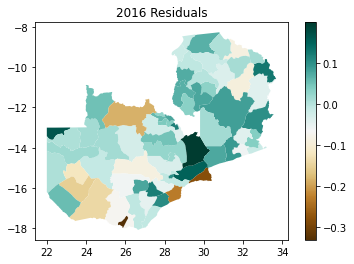

In [46]:
residual_gdf[residual_gdf.year == 2016].plot(column = "residual", legend = True, cmap = "BrBG")
plt.title("2016 Residuals")

<Figure size 432x288 with 0 Axes>

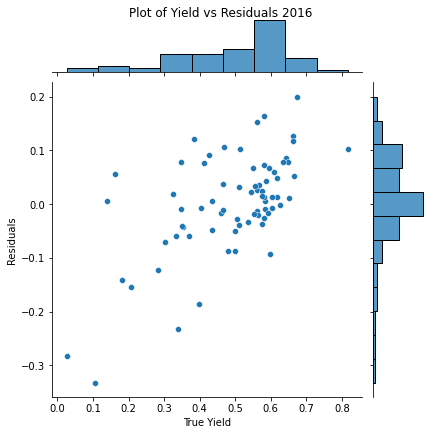

In [47]:
import seaborn as sns



true_yield_2016 = residual_gdf[residual_gdf.year == 2016]['yield']
residual_2016 = residual_gdf[residual_gdf.year == 2016]['residual']




plt.figure()

p = sns.jointplot(x=true_yield_2016, y = residual_2016)
# plt.scatter(true_yield_2016, residual_2016, alpha=1, s=4)
p.set_axis_labels("True Yield", "Residuals")
# p.axhline(0)
plt.suptitle("Plot of Yield vs Residuals 2016",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



plt.show()
plt.close()

Text(0.5, 1.0, '2017 Residuals')

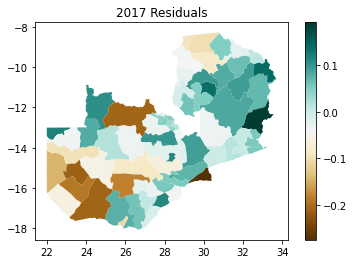

In [48]:
residual_gdf[residual_gdf.year == 2017].plot(column = "residual", legend = True, cmap = "BrBG")
plt.title("2017 Residuals")

<Figure size 432x288 with 0 Axes>

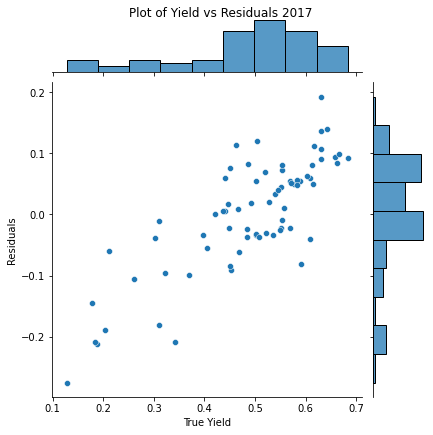

In [49]:
true_yield_2017 = residual_gdf[residual_gdf.year == 2017]['yield']
residual_2017 = residual_gdf[residual_gdf.year == 2017]['residual']

plt.figure()

p = sns.jointplot(x=true_yield_2017, y = residual_2017)

p.set_axis_labels("True Yield", "Residuals")
# p.axhline(0)
plt.suptitle("Plot of Yield vs Residuals 2017",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



plt.show()
plt.close()

Text(0.5, 1.0, '2018 Residuals')

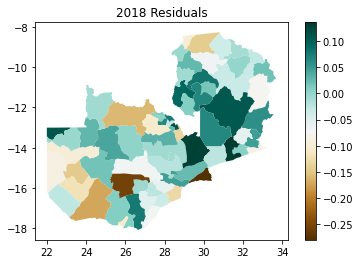

In [50]:
residual_gdf[residual_gdf.year == 2018].plot(column = "residual", legend = True, cmap = "BrBG")
plt.title("2018 Residuals")

<Figure size 432x288 with 0 Axes>

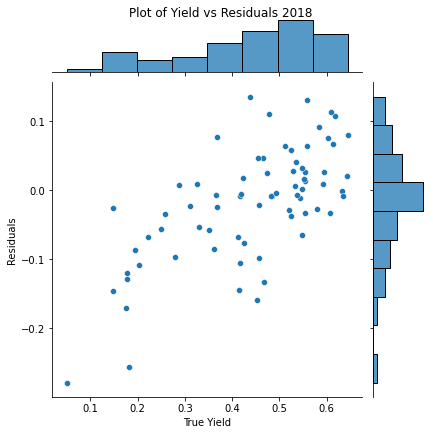

In [51]:
true_yield_2018 = residual_gdf[residual_gdf.year == 2018]['yield']
residual_2018 = residual_gdf[residual_gdf.year == 2018]['residual']

plt.figure()

p = sns.jointplot(x=true_yield_2018, y = residual_2018)
p.set_axis_labels("True Yield", "Residuals")
# p.axhline(0)
plt.suptitle("Plot of Yield vs Residuals 2018",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



plt.show()
plt.close()

# All Residual Plots

Text(0.5, 0.01, 'A positive value is an underestimated prediction (the prediction is lower than the actual yield), a negative value is an over estimated prediction')

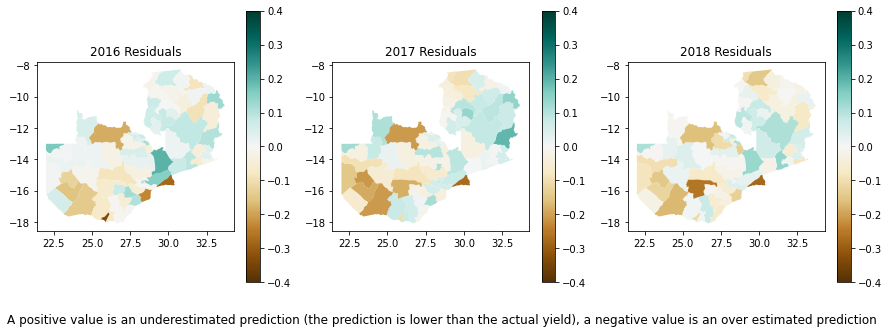

In [52]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax1 = residual_gdf[residual_gdf.year == 2016].plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG").set_title("2016 Residuals")
ax2 = residual_gdf[residual_gdf.year == 2017].plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG").set_title("2017 Residuals")
ax3 = residual_gdf[residual_gdf.year == 2018].plot(ax = ax3, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG").set_title("2018 Residuals")
caption = "A positive value is an underestimated prediction (the prediction is lower than the actual yield), a negative value is an over estimated prediction"
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

Text(0.5, 1.0, '2018 Residuals')

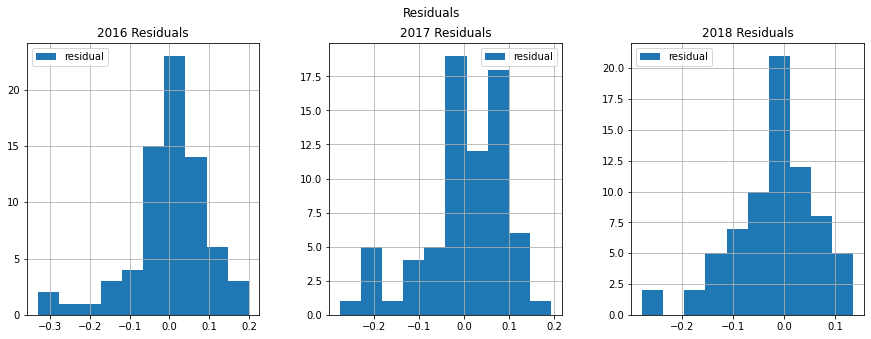

In [53]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.suptitle("Residuals")
plt.ax1 = residual_gdf[residual_gdf.year == 2016].hist(ax = ax1, column = "residual", legend = True)
ax1.set_title("2016 Residuals")
plt.ax2 = residual_gdf[residual_gdf.year == 2017].hist(ax = ax2, column = "residual", legend = True) 
ax2.set_title("2017 Residuals")
plt.ax3 = residual_gdf[residual_gdf.year == 2018].hist(ax = ax3, column = "residual", legend = True)
ax3.set_title("2018 Residuals")

In [54]:
residual_gdf.residual.min()

-0.33186758683307355

In [55]:
residual_gdf.residual.max()

0.1998017377805038

# Difference from the Mean

In [56]:
residual_gdf_2016 = residual_gdf[residual_gdf.year == 2016]
residual_gdf_2017 = residual_gdf[residual_gdf.year == 2017]
residual_gdf_2018 = residual_gdf[residual_gdf.year == 2018]

Text(0, 0.5, 'Difference from Predictions Mean')

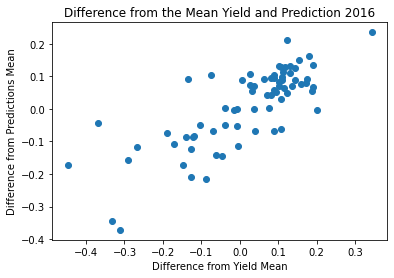

In [57]:
plt.scatter(residual_gdf_2016["demean_yield"], residual_gdf_2016["demean_prediction"])
plt.title("Difference from the Mean Yield and Prediction 2016")
plt.xlabel("Difference from Yield Mean")
plt.ylabel("Difference from Predictions Mean")

Text(0, 0.5, 'Difference from Predictions Mean')

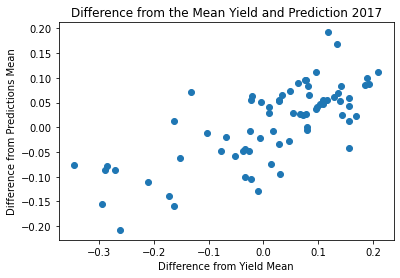

In [74]:
plt.scatter(residual_gdf_2017["demean_yield"], residual_gdf_2017["demean_prediction"])
plt.title("Difference from the Mean Yield and Prediction 2017")
plt.xlabel("Difference from Yield Mean")
plt.ylabel("Difference from Predictions Mean")

Text(0, 0.5, 'Difference from Predictions Mean')

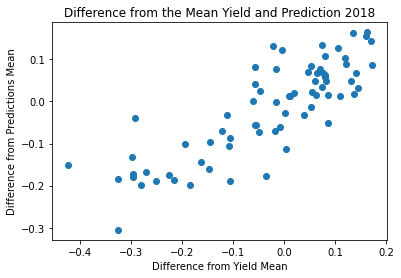

In [101]:
plt.scatter(residual_gdf_2018["demean_yield"], residual_gdf_2018["demean_prediction"])
plt.title("Difference from the Mean Yield and Prediction 2018")
plt.xlabel("Difference from Yield Mean")
plt.ylabel("Difference from Predictions Mean")

Text(0, 0.5, 'Difference from Predictions Mean')

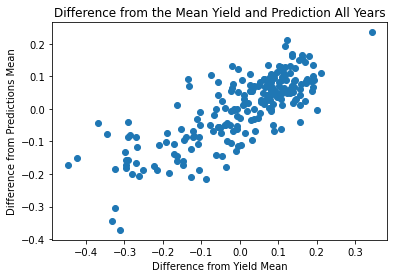

In [97]:
# all years
plt.scatter(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
plt.title("Difference from the Mean Yield and Prediction All Years")
plt.xlabel("Difference from Yield Mean")
plt.ylabel("Difference from Predictions Mean")

In [100]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

r_squared_2016 = r2_score(residual_gdf_2016["demean_yield"], residual_gdf_2016["demean_prediction"])
print("2016 R^2: ", r_squared_2016)
pearsonr_2016 = pearsonr(residual_gdf_2016["demean_yield"], residual_gdf_2016["demean_prediction"])
print("2016 Pearson's: ", pearsonr_2016[0])
print("")

r_squared_2017 = r2_score(residual_gdf_2017["demean_yield"], residual_gdf_2017["demean_prediction"])
print("2017 R^2: ", r_squared_2017)
pearsonr_2017 = pearsonr(residual_gdf_2017["demean_yield"], residual_gdf_2017["demean_prediction"])
print("2017 Pearson's: ", pearsonr_2017[0])
print("")

r_squared_2018 = r2_score(residual_gdf_2018["demean_yield"], residual_gdf_2018["demean_prediction"])
print("2018 R^2: ", r_squared_2018)
pearsonr_2018 = pearsonr(residual_gdf_2018["demean_yield"], residual_gdf_2018["demean_prediction"])
print("2018 Pearson's: ", pearsonr_2018[0])
print("")

r_squared_allyrs = r2_score(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
print("All Years R^2: ", r_squared_allyrs)
pearsonr_allyrs = pearsonr(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
print("All Years Pearson's: ", pearsonr_allyrs[0])

2016 R^2:  0.6127413799668886
2016 Pearson's:  0.7841234558703599

2017 R^2:  0.501758595849502
2017 Pearson's:  0.720260257881092

2018 R^2:  0.6783452114901662
2018 Pearson's:  0.8324524714010397

All Years R^2:  0.6141110662516216
All Years Pearson's:  0.7860533173853546


Text(0, 0.5, 'y axis')

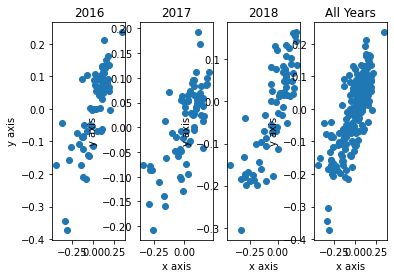

In [102]:
x1 = residual_gdf_2016["demean_yield"]
y1 = residual_gdf_2016["demean_prediction"]

x2 = residual_gdf_2017["demean_yield"]
y2 = residual_gdf_2017["demean_prediction"]

x3 = residual_gdf_2018["demean_yield"]
y3 = residual_gdf_2018["demean_prediction"]

x4 = residual_gdf["demean_yield"]
y4 = residual_gdf["demean_prediction"]

plt.tight_layout()

plt.subplot(1, 4, 1)
plt.scatter(x1, y1)
plt.title('2016')
plt.ylabel('y axis')

plt.subplot(1, 4, 2)
plt.scatter(x2, y2)
plt.title("2017")
plt.xlabel('x axis')
plt.ylabel('y axis')

plt.subplot(1, 4, 3)
plt.scatter(x3, y3)
plt.title("2018")
plt.xlabel('x axis')
plt.ylabel('y axis')

plt.subplot(1, 4, 4)
plt.scatter(x4, y4)
plt.title("All Years")
plt.xlabel('x axis')
plt.ylabel('y axis')

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.suptitle("Difference from the Mean Yield and Prediction")

plt.ax1 = residual_gdf_2016.plot("demean_yield", "demean_prediction", ax = ax1)
ax1.set_title("2016")


plt.ax1 = residual_gdf_2017.plot("demean_yield", "demean_prediction", ax = ax1)
ax1.set_title("2017")


plt.ax1 = residual_gdf_2018.plot("demean_yield", "demean_prediction", ax = ax1)
ax1.set_title("2018")
# plt.ax2 = plt.scatter(residual_df_2017["demean_yield"], residual_df_2017["demean_prediction"]) 
# ax2.set_title("2017")

# plt.ax3 = plt.scatter(residual_df_2018["demean_yield"], residual_df_2018["demean_prediction"])
# ax1.set_title("2018")